# Prepare audio data for image recognition

We then generate spectrograms of each word. We mix in background noise with the words to make it a more realistic audio sample.

## Download data set
Download from: https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz - approx 2.3 GB

And then run
```
tar -xzf data_speech_commands_v0.02.tar.gz -C speech_data
```

In [1]:
!wget --max-redirect=20 --trust-server-names https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz -O speech_commands_v0.02.tar.gz


--2024-11-19 21:17:31--  https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.251.175.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  11.2MB/s    in 3m 35s  

2024-11-19 21:21:06 (10.8 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
!file speech_commands_v0.02.tar.gz

!ls -l

speech_commands_v0.02.tar.gz: gzip compressed data, last modified: Wed Apr 11 17:56:01 2018, from Unix, original size modulo 2^32 3417661440
total 2372008
drwxr-xr-x 1 root root       4096 Nov  7 20:56 sample_data
-rw-r--r-- 1 root root 2428923189 Apr 11  2018 speech_commands_v0.02.tar.gz
drwxr-xr-x 2 root root       4096 Nov 11 10:53 speech_data


In [2]:
!tar -xzf speech_commands_v0.02.tar.gz -C speech_data

In [ ]:
!pip install tensorflow_io
import tensorflow as tf
import numpy as np
import tensorflow_io as tfio
from tensorflow.io import gfile
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
SPEECH_DATA='./speech_data'

In [ ]:
# The audio is all sampled at 16KHz and should all be 1 second in length - and 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be above the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [ ]:
# list of folders we want to process in the speech_data folder
command_words = [
    'chickenrice',
    'salad',
    'fishsoup',
    '_invalid',
]
nonsense_words = [
    'go',
    'on',
    'off',
    'up',
    'down',
    'learn'
]

In [ ]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    # print("before check is correct length")
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    # print("after check is correct length")
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [ ]:
!pip install ffmpeg-python


In [ ]:
import ffmpeg
import os

def convert_and_resample_m4a_to_wav(input_file, output_file, target_sample_rate=16000):
    try:
        (
            ffmpeg
            .input(input_file)
            .output(output_file, ac=1, ar=target_sample_rate, format='wav')
            .run(overwrite_output=True, capture_stdout=True, capture_stderr=True)
        )
    except ffmpeg.Error as e:
        print('Error:', e.stderr.decode())  # Print stderr output

for folder in command_words:
  if '_' not in folder:
      directory = SPEECH_DATA + '/' + folder
      filenames = [os.path.join(directory, file) for file in os.listdir(directory)]
      print(filenames)
      for filename in filenames:
        if '.ipynb_checkpoints' not in filename:
          convert_and_resample_m4a_to_wav(filename, filename.split('.')[0] + 'wav')

['./speech_data/chickenrice/Chicken Rice 12.wav', './speech_data/chickenrice/Chicken Rice 13.wav', './speech_data/chickenrice/.ipynb_checkpoints', './speech_data/chickenrice/Chicken Rice 1.wav', './speech_data/chickenrice/Chicken Rice 11.wav', './speech_data/chickenrice/Chicken rice 6.wav', './speech_data/chickenrice/Chicken Rice 5.wav', './speech_data/chickenrice/Chicken rice 2.wav', './speech_data/chickenrice/Chicken Rice 9.wav', './speech_data/chickenrice/Chicken Rice 7.wav', './speech_data/chickenrice/Chicken Rice 10.wav', './speech_data/chickenrice/Chicken Rice 8.wav', './speech_data/chickenrice/Chicken rice 3.wav', './speech_data/chickenrice/Chicken rice 4.wav']
['./speech_data/salad/Salad-10.wav', './speech_data/salad/Salad-8.wav', './speech_data/salad/Salad-12.wav', './speech_data/salad/.ipynb_checkpoints', './speech_data/salad/Salad-7.wav', './speech_data/salad/Salad-4.wav', './speech_data/salad/Salad-6.wav', './speech_data/salad/Salad-2.wav', './speech_data/salad/Salad-5.wav'

In [ ]:
import librosa
import numpy as np
import soundfile as sf

# Resample to 16,000 Hz
target_sr = 16000
# Ensure the audio has exactly 16,000 samples
target_length = 16000


def preprocess(filename):
  # Load the audio file
  audio, original_sr = librosa.load(filename, sr=None)
  if len(audio) == target_length:
    return

  audio_resampled = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)

  if len(audio_resampled) > target_length:
      audio_resampled = audio_resampled[:target_length]
  elif len(audio_resampled) < target_length:
      audio_resampled = np.pad(audio_resampled, (0, target_length - len(audio_resampled)), 'constant')

  # Save the result as a WAV file
  sf.write(filename, audio_resampled, target_sr)

for folder in command_words:
  if '_' not in folder:
      filenames = [file_name for file_name in tqdm(get_files(folder), desc="Checking", leave=False)]
      for filename in filenames:
        preprocess(filename)



Checking:   0%|          | 0/113 [00:00<?, ?it/s]

Checking:   0%|          | 0/114 [00:00<?, ?it/s]

Checking:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [ ]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [ ]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [ ]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, label, repeat=1):
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the command words
for word in tqdm(command_words, desc="Processing words"):
    if '_' not in word:
        repeat = 10 if word in ('salad','chickenrice', 'fishsoup') else 10
        process_word(word, command_words.index(word), repeat=repeat)

# all the nonsense words
for word in tqdm(nonsense_words, desc="Processing words"):
    if '_' not in word:
        process_word(word, command_words.index('_invalid'), repeat=1)

print(len(train), len(test), len(validate))

Processing words:   0%|          | 0/4 [00:00<?, ?it/s]

Checking:   0%|          | 0/113 [00:00<?, ?it/s]

chickenrice (0):   0%|          | 0/900 [00:00<?, ?it/s]

chickenrice (0):   0%|          | 0/110 [00:00<?, ?it/s]

chickenrice (0):   0%|          | 0/120 [00:00<?, ?it/s]

Checking:   0%|          | 0/114 [00:00<?, ?it/s]

salad (1):   0%|          | 0/890 [00:00<?, ?it/s]

salad (1):   0%|          | 0/110 [00:00<?, ?it/s]

salad (1):   0%|          | 0/120 [00:00<?, ?it/s]

Checking:   0%|          | 0/113 [00:00<?, ?it/s]

fishsoup (2):   0%|          | 0/900 [00:00<?, ?it/s]

fishsoup (2):   0%|          | 0/110 [00:00<?, ?it/s]

fishsoup (2):   0%|          | 0/120 [00:00<?, ?it/s]

Processing words:   0%|          | 0/7 [00:00<?, ?it/s]

Checking: 0it [00:00, ?it/s]

please (3): 0it [00:00, ?it/s]

please (3): 0it [00:00, ?it/s]

please (3): 0it [00:00, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

go (3):   0%|          | 0/2157 [00:00<?, ?it/s]

go (3):   0%|          | 0/269 [00:00<?, ?it/s]

go (3):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/3845 [00:00<?, ?it/s]

on (3):   0%|          | 0/2390 [00:00<?, ?it/s]

on (3):   0%|          | 0/298 [00:00<?, ?it/s]

on (3):   0%|          | 0/300 [00:00<?, ?it/s]

Checking:   0%|          | 0/3745 [00:00<?, ?it/s]

off (3):   0%|          | 0/1188 [00:00<?, ?it/s]

off (3):   0%|          | 0/148 [00:00<?, ?it/s]

off (3):   0%|          | 0/150 [00:00<?, ?it/s]

Checking:   0%|          | 0/3723 [00:00<?, ?it/s]

up (3):   0%|          | 0/790 [00:00<?, ?it/s]

up (3):   0%|          | 0/98 [00:00<?, ?it/s]

up (3):   0%|          | 0/100 [00:00<?, ?it/s]

Checking:   0%|          | 0/3917 [00:00<?, ?it/s]

down (3):   0%|          | 0/2623 [00:00<?, ?it/s]

down (3):   0%|          | 0/327 [00:00<?, ?it/s]

down (3):   0%|          | 0/329 [00:00<?, ?it/s]

Checking:   0%|          | 0/1575 [00:00<?, ?it/s]

learn (3):   0%|          | 0/1096 [00:00<?, ?it/s]

learn (3):   0%|          | 0/137 [00:00<?, ?it/s]

learn (3):   0%|          | 0/137 [00:00<?, ?it/s]

12934 1647 1607


In [ ]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))


    np.random.shuffle(samples)

    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))

    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))

print(len(train), len(test), len(validate))

Processing Background Noise:   0%|          | 0/6 [00:00<?, ?it/s]

./speech_data/_background_noise_/dude_miaowing.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

./speech_data/_background_noise_/running_tap.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

./speech_data/_background_noise_/doing_the_dishes.wav:   0%|          | 0/95 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

./speech_data/_background_noise_/white_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

./speech_data/_background_noise_/pink_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

./speech_data/_background_noise_/exercise_bike.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

18048 2292 2244


In [ ]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    np.random.shuffle(samples)

    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))

    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))

Processing problem noise: 0it [00:00, ?it/s]

In [ ]:
print(len(train), len(test), len(validate))

18048 2292 2244


In [ ]:
# randomise the training samples
np.random.shuffle(train)

In [ ]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [ ]:
testlenC = [i for i in Y_train if i== 0]
testlenF = [i for i in Y_train if i == 2]
testlenS = [i for i in Y_train if i == 1]
print(len(testlenC))
print(len(testlenF))
print(len(testlenS))

900
900
890


In [ ]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [ ]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [ ]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()


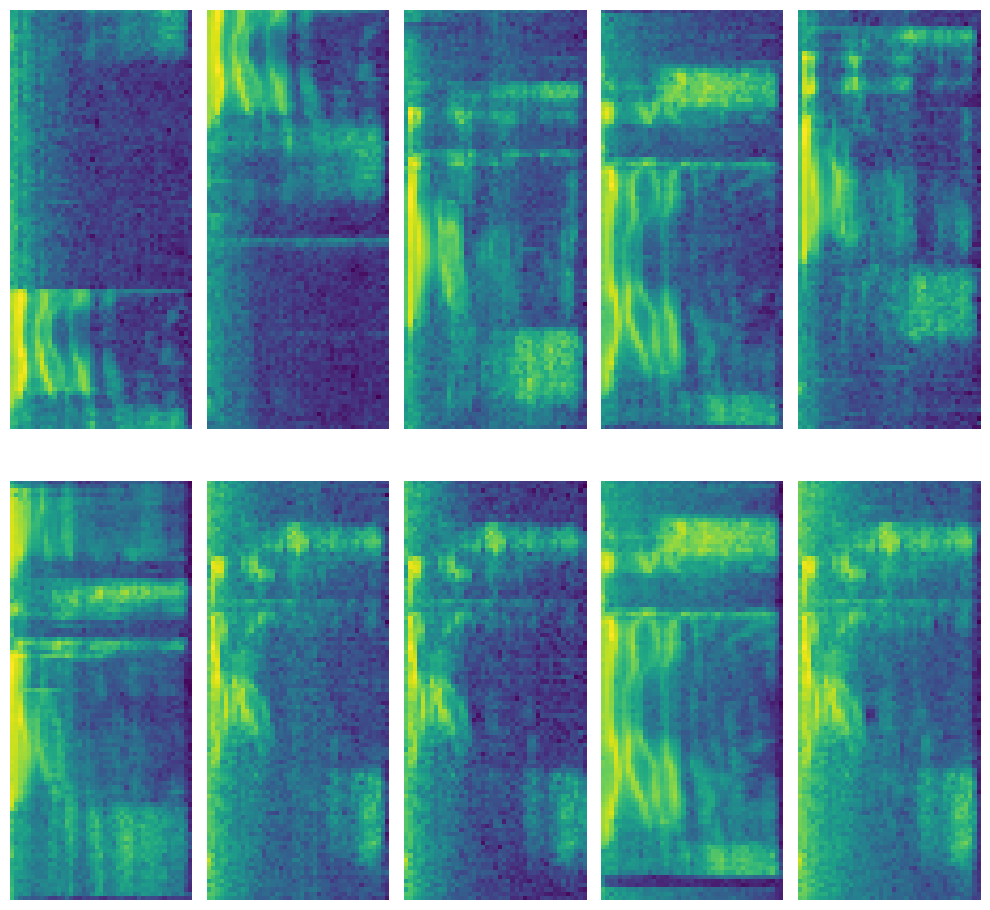

In [ ]:
word_index = command_words.index("chickenrice")

X_left = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_left[:10], IMG_WIDTH, IMG_HEIGHT)